In [1]:
import tensorflow as tf
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras import regularizers
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import time
import h5py
import kerastuner as kt

Using TensorFlow backend.


In [2]:
def processing_data(N_channels, file_path):
    df = pd.read_csv(file_path)
    # dataset
    dataset = df.values
    # input power and channels statuses
    X = dataset[:,0:N_channels+1]
    # channel SNRs
    Y = dataset[:,N_channels+1:2*N_channels+1]
    # shuffle necessary because while shuffle=True in .fit() shuffles the data, it splits into different datasets first
    X, Y = shuffle(X, Y)
    # scaling between 0 and 1
    min_max_scaler = preprocessing.MinMaxScaler()
    X = min_max_scaler.fit_transform(X)
    Y = min_max_scaler.fit_transform(Y)
    return X, Y
# X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X_scale, Y_scale, test_size=0.3)
# X_train, X_val, Y_train, Y_val = train_test_split(X_scale, Y_scale, test_size=0.2)
N_channels = 40
file_path = '/Users/jackkelly/Desktop/Building_Model/Data/40_channels_data_blocks_20000.csv'
X_scale, Y_scale = processing_data(N_channels, file_path)

In [3]:
def model_builder(hp):
    model = keras.Sequential()
    model.add(keras.layers.InputLayer(input_shape=N_channels+1))
    for i in range(hp.Int('n_layers', 1, 4)):
        model.add(keras.layers.Dense(hp.Int(f'hidden_{i}_units', min_value=32, max_value=320, step=1)))
    model.add(keras.layers.Dense(N_channels, activation='sigmoid'))
    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.MeanSquaredError(), metrics=['mean_squared_error'])

    return model

In [4]:
# max epochs can be high as we have earlystopping
tuner = kt.Hyperband(model_builder,
                     objective=kt.Objective('mean_squared_error', 'min'),
                     max_epochs=40,
                     factor=3,
                     directory='/Users/jackkelly/Desktop/Building_Model/',
                     project_name='intro_to_kt_layers',
                     overwrite=True)
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [5]:
tuner.search(X_scale, Y_scale, epochs=50, validation_split=0.25, callbacks=[stop_early], verbose=2)

Train on 15000 samples, validate on 5000 samples
Epoch 1/2
15000/15000 - 3s - loss: 0.0347 - mean_squared_error: 0.0347 - val_loss: 0.0254 - val_mean_squared_error: 0.0254
Epoch 2/2
15000/15000 - 1s - loss: 0.0245 - mean_squared_error: 0.0245 - val_loss: 0.0289 - val_mean_squared_error: 0.0289


Train on 15000 samples, validate on 5000 samples
Epoch 1/2
15000/15000 - 2s - loss: 0.1574 - mean_squared_error: 0.1574 - val_loss: 0.1220 - val_mean_squared_error: 0.1220
Epoch 2/2
15000/15000 - 1s - loss: 0.0913 - mean_squared_error: 0.0913 - val_loss: 0.0653 - val_mean_squared_error: 0.0653


Train on 15000 samples, validate on 5000 samples
Epoch 1/2
15000/15000 - 2s - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 6.0981e-04 - val_mean_squared_error: 6.0981e-04
Epoch 2/2
15000/15000 - 1s - loss: 7.4800e-04 - mean_squared_error: 7.4800e-04 - val_loss: 0.0010 - val_mean_squared_error: 0.0010


Train on 15000 samples, validate on 5000 samples
Epoch 1/2
15000/15000 - 2s - loss: 0.0260 - mean_squared_error: 0.0260 - val_loss: 7.6352e-04 - val_mean_squared_error: 7.6352e-04
Epoch 2/2
15000/15000 - 2s - loss: 5.0368e-04 - mean_squared_error: 5.0368e-04 - val_loss: 4.2140e-04 - val_mean_squared_error: 4.2140e-04


Train on 15000 samples, validate on 5000 samples
Epoch 1/2
15000/15000 - 3s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 0.0030 - val_mean_squared_error: 0.0030
Epoch 2/2
15000/15000 - 2s - loss: 0.3104 - mean_squared_error: 0.3104 - val_loss: 0.3959 - val_mean_squared_error: 0.3959


Train on 15000 samples, validate on 5000 samples
Epoch 1/2
15000/15000 - 3s - loss: 0.2065 - mean_squared_error: 0.2065 - val_loss: 0.3873 - val_mean_squared_error: 0.3873
Epoch 2/2
15000/15000 - 2s - loss: 0.3854 - mean_squared_error: 0.3854 - val_loss: 0.3873 - val_mean_squared_error: 0.3873


Train on 15000 samples, validate on 5000 samples
Epoch 1/2
15000/15000 - 2s - loss: 0.0086 - mean_squared_error: 0.0086 - val_loss: 6.3795e-04 - val_mean_squared_error: 6.3795e-04
Epoch 2/2
15000/15000 - 1s - loss: 6.0878e-04 - mean_squared_error: 6.0878e-04 - val_loss: 6.5817e-04 - val_mean_squared_error: 6.5817e-04


Train on 15000 samples, validate on 5000 samples
Epoch 1/2
15000/15000 - 3s - loss: 0.1131 - mean_squared_error: 0.1131 - val_loss: 0.0514 - val_mean_squared_error: 0.0514
Epoch 2/2
15000/15000 - 2s - loss: 0.0269 - mean_squared_error: 0.0269 - val_loss: 0.0117 - val_mean_squared_error: 0.0117


Train on 15000 samples, validate on 5000 samples
Epoch 1/2
15000/15000 - 2s - loss: 0.0302 - mean_squared_error: 0.0302 - val_loss: 0.0259 - val_mean_squared_error: 0.0259
Epoch 2/2
15000/15000 - 2s - loss: 0.0375 - mean_squared_error: 0.0375 - val_loss: 0.0740 - val_mean_squared_error: 0.0740


Train on 15000 samples, validate on 5000 samples
Epoch 1/2
15000/15000 - 2s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 9.9497e-04 - val_mean_squared_error: 9.9497e-04
Epoch 2/2
15000/15000 - 2s - loss: 0.0286 - mean_squared_error: 0.0286 - val_loss: 0.1580 - val_mean_squared_error: 0.1580


Train on 15000 samples, validate on 5000 samples
Epoch 1/2
15000/15000 - 3s - loss: 0.0101 - mean_squared_error: 0.0101 - val_loss: 0.0679 - val_mean_squared_error: 0.0679
Epoch 2/2
15000/15000 - 2s - loss: 0.3732 - mean_squared_error: 0.3732 - val_loss: 0.4161 - val_mean_squared_error: 0.4161


Train on 15000 samples, validate on 5000 samples
Epoch 1/2
15000/15000 - 2s - loss: 0.1574 - mean_squared_error: 0.1574 - val_loss: 0.1222 - val_mean_squared_error: 0.1222
Epoch 2/2
15000/15000 - 2s - loss: 0.0918 - mean_squared_error: 0.0918 - val_loss: 0.0659 - val_mean_squared_error: 0.0659


Train on 15000 samples, validate on 5000 samples
Epoch 1/2
15000/15000 - 2s - loss: 0.1586 - mean_squared_error: 0.1586 - val_loss: 0.1212 - val_mean_squared_error: 0.1212
Epoch 2/2
15000/15000 - 2s - loss: 0.0914 - mean_squared_error: 0.0914 - val_loss: 0.0705 - val_mean_squared_error: 0.0705


Train on 15000 samples, validate on 5000 samples
Epoch 1/2
15000/15000 - 3s - loss: 0.0237 - mean_squared_error: 0.0237 - val_loss: 4.8711e-04 - val_mean_squared_error: 4.8711e-04
Epoch 2/2
15000/15000 - 2s - loss: 4.8691e-04 - mean_squared_error: 4.8691e-04 - val_loss: 5.5488e-04 - val_mean_squared_error: 5.5488e-04


Train on 15000 samples, validate on 5000 samples
Epoch 1/2
15000/15000 - 2s - loss: 0.0224 - mean_squared_error: 0.0224 - val_loss: 4.5467e-04 - val_mean_squared_error: 4.5467e-04
Epoch 2/2
15000/15000 - 2s - loss: 4.5397e-04 - mean_squared_error: 4.5397e-04 - val_loss: 4.2310e-04 - val_mean_squared_error: 4.2310e-04


Train on 15000 samples, validate on 5000 samples
Epoch 1/2
15000/15000 - 3s - loss: 0.0155 - mean_squared_error: 0.0155 - val_loss: 4.5045e-04 - val_mean_squared_error: 4.5045e-04
Epoch 2/2
15000/15000 - 2s - loss: 4.8619e-04 - mean_squared_error: 4.8619e-04 - val_loss: 3.8379e-04 - val_mean_squared_error: 3.8379e-04


Train on 15000 samples, validate on 5000 samples
Epoch 1/2
15000/15000 - 4s - loss: 0.0672 - mean_squared_error: 0.0672 - val_loss: 0.0089 - val_mean_squared_error: 0.0089
Epoch 2/2
15000/15000 - 3s - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0010 - val_mean_squared_error: 0.0010


Train on 15000 samples, validate on 5000 samples
Epoch 1/2
15000/15000 - 2s - loss: 0.0433 - mean_squared_error: 0.0433 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 2/2
15000/15000 - 1s - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 6.8560e-04 - val_mean_squared_error: 6.8560e-04


Train on 15000 samples, validate on 5000 samples
Epoch 1/2
15000/15000 - 2s - loss: 0.0067 - mean_squared_error: 0.0067 - val_loss: 6.3911e-04 - val_mean_squared_error: 6.3911e-04
Epoch 2/2
15000/15000 - 1s - loss: 7.3309e-04 - mean_squared_error: 7.3309e-04 - val_loss: 7.5658e-04 - val_mean_squared_error: 7.5658e-04


Train on 15000 samples, validate on 5000 samples
Epoch 1/2
15000/15000 - 2s - loss: 0.1652 - mean_squared_error: 0.1652 - val_loss: 0.1351 - val_mean_squared_error: 0.1351
Epoch 2/2
15000/15000 - 1s - loss: 0.1081 - mean_squared_error: 0.1081 - val_loss: 0.0830 - val_mean_squared_error: 0.0830


Train on 15000 samples, validate on 5000 samples
Epoch 1/2
15000/15000 - 2s - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 2/2
15000/15000 - 2s - loss: 0.0527 - mean_squared_error: 0.0527 - val_loss: 0.2413 - val_mean_squared_error: 0.2413


Train on 15000 samples, validate on 5000 samples
Epoch 1/2
15000/15000 - 2s - loss: 0.1622 - mean_squared_error: 0.1622 - val_loss: 0.1281 - val_mean_squared_error: 0.1281
Epoch 2/2
15000/15000 - 1s - loss: 0.0985 - mean_squared_error: 0.0985 - val_loss: 0.0721 - val_mean_squared_error: 0.0721


Train on 15000 samples, validate on 5000 samples
Epoch 1/2
15000/15000 - 2s - loss: 0.0079 - mean_squared_error: 0.0079 - val_loss: 7.2857e-04 - val_mean_squared_error: 7.2857e-04
Epoch 2/2
15000/15000 - 2s - loss: 9.7346e-04 - mean_squared_error: 9.7346e-04 - val_loss: 0.0014 - val_mean_squared_error: 0.0014


Train on 15000 samples, validate on 5000 samples
Epoch 1/2
15000/15000 - 3s - loss: 0.1244 - mean_squared_error: 0.1244 - val_loss: 0.0687 - val_mean_squared_error: 0.0687
Epoch 2/2
15000/15000 - 2s - loss: 0.0402 - mean_squared_error: 0.0402 - val_loss: 0.0198 - val_mean_squared_error: 0.0198


Train on 15000 samples, validate on 5000 samples
Epoch 1/2
15000/15000 - 2s - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 2/2
15000/15000 - 2s - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0018 - val_mean_squared_error: 0.0018


Train on 15000 samples, validate on 5000 samples
Epoch 1/2
15000/15000 - 3s - loss: 0.1231 - mean_squared_error: 0.1231 - val_loss: 0.0702 - val_mean_squared_error: 0.0702
Epoch 2/2
15000/15000 - 2s - loss: 0.0471 - mean_squared_error: 0.0471 - val_loss: 0.0314 - val_mean_squared_error: 0.0314


Train on 15000 samples, validate on 5000 samples
Epoch 1/2
15000/15000 - 2s - loss: 0.1804 - mean_squared_error: 0.1804 - val_loss: 0.1572 - val_mean_squared_error: 0.1572
Epoch 2/2
15000/15000 - 1s - loss: 0.1369 - mean_squared_error: 0.1369 - val_loss: 0.1173 - val_mean_squared_error: 0.1173


Train on 15000 samples, validate on 5000 samples
Epoch 1/2
15000/15000 - 3s - loss: 0.1219 - mean_squared_error: 0.1219 - val_loss: 0.0661 - val_mean_squared_error: 0.0661
Epoch 2/2
15000/15000 - 2s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0213 - val_mean_squared_error: 0.0213


Train on 15000 samples, validate on 5000 samples
Epoch 1/2
15000/15000 - 2s - loss: 0.1433 - mean_squared_error: 0.1433 - val_loss: 0.0916 - val_mean_squared_error: 0.0916
Epoch 2/2
15000/15000 - 2s - loss: 0.0610 - mean_squared_error: 0.0610 - val_loss: 0.0393 - val_mean_squared_error: 0.0393


Train on 15000 samples, validate on 5000 samples
Epoch 1/2
15000/15000 - 3s - loss: 0.0139 - mean_squared_error: 0.0139 - val_loss: 0.0173 - val_mean_squared_error: 0.0173
Epoch 2/2
15000/15000 - 2s - loss: 0.4144 - mean_squared_error: 0.4144 - val_loss: 0.4338 - val_mean_squared_error: 0.4338


Train on 15000 samples, validate on 5000 samples
Epoch 1/2
15000/15000 - 3s - loss: 0.2055 - mean_squared_error: 0.2055 - val_loss: 0.4181 - val_mean_squared_error: 0.4181
Epoch 2/2
15000/15000 - 2s - loss: 0.4149 - mean_squared_error: 0.4149 - val_loss: 0.4125 - val_mean_squared_error: 0.4125


Train on 15000 samples, validate on 5000 samples
Epoch 1/2
15000/15000 - 3s - loss: 0.1244 - mean_squared_error: 0.1244 - val_loss: 0.0643 - val_mean_squared_error: 0.0643
Epoch 2/2
15000/15000 - 2s - loss: 0.0369 - mean_squared_error: 0.0369 - val_loss: 0.0185 - val_mean_squared_error: 0.0185


Train on 15000 samples, validate on 5000 samples
Epoch 1/2
15000/15000 - 3s - loss: 0.1378 - mean_squared_error: 0.1378 - val_loss: 0.3922 - val_mean_squared_error: 0.3922
Epoch 2/2
15000/15000 - 2s - loss: 0.4149 - mean_squared_error: 0.4149 - val_loss: 0.4602 - val_mean_squared_error: 0.4602


Train on 15000 samples, validate on 5000 samples
Epoch 1/2
15000/15000 - 3s - loss: 0.1244 - mean_squared_error: 0.1244 - val_loss: 0.0649 - val_mean_squared_error: 0.0649
Epoch 2/2
15000/15000 - 2s - loss: 0.0379 - mean_squared_error: 0.0379 - val_loss: 0.0194 - val_mean_squared_error: 0.0194


Train on 15000 samples, validate on 5000 samples
Epoch 3/5
15000/15000 - 2s - loss: 0.0232 - mean_squared_error: 0.0232 - val_loss: 4.6876e-04 - val_mean_squared_error: 4.6876e-04
Epoch 4/5
15000/15000 - 2s - loss: 4.9325e-04 - mean_squared_error: 4.9325e-04 - val_loss: 6.0363e-04 - val_mean_squared_error: 6.0363e-04
Epoch 5/5
15000/15000 - 2s - loss: 4.0563e-04 - mean_squared_error: 4.0563e-04 - val_loss: 3.7331e-04 - val_mean_squared_error: 3.7331e-04


Train on 15000 samples, validate on 5000 samples
Epoch 3/5
15000/15000 - 3s - loss: 0.0160 - mean_squared_error: 0.0160 - val_loss: 4.5100e-04 - val_mean_squared_error: 4.5100e-04
Epoch 4/5
15000/15000 - 2s - loss: 4.5429e-04 - mean_squared_error: 4.5429e-04 - val_loss: 3.8154e-04 - val_mean_squared_error: 3.8154e-04
Epoch 5/5
15000/15000 - 2s - loss: 4.4993e-04 - mean_squared_error: 4.4993e-04 - val_loss: 4.3031e-04 - val_mean_squared_error: 4.3031e-04


Train on 15000 samples, validate on 5000 samples
Epoch 3/5
15000/15000 - 2s - loss: 0.0241 - mean_squared_error: 0.0241 - val_loss: 4.8209e-04 - val_mean_squared_error: 4.8209e-04
Epoch 4/5
15000/15000 - 2s - loss: 4.9380e-04 - mean_squared_error: 4.9380e-04 - val_loss: 3.7451e-04 - val_mean_squared_error: 3.7451e-04
Epoch 5/5
15000/15000 - 2s - loss: 5.0342e-04 - mean_squared_error: 5.0342e-04 - val_loss: 4.0651e-04 - val_mean_squared_error: 4.0651e-04


Train on 15000 samples, validate on 5000 samples
Epoch 3/5
15000/15000 - 2s - loss: 0.0279 - mean_squared_error: 0.0279 - val_loss: 6.5362e-04 - val_mean_squared_error: 6.5362e-04
Epoch 4/5
15000/15000 - 2s - loss: 4.9563e-04 - mean_squared_error: 4.9563e-04 - val_loss: 3.7320e-04 - val_mean_squared_error: 3.7320e-04
Epoch 5/5
15000/15000 - 2s - loss: 3.9746e-04 - mean_squared_error: 3.9746e-04 - val_loss: 3.8348e-04 - val_mean_squared_error: 3.8348e-04


Train on 15000 samples, validate on 5000 samples
Epoch 3/5
15000/15000 - 2s - loss: 0.0085 - mean_squared_error: 0.0085 - val_loss: 8.0535e-04 - val_mean_squared_error: 8.0535e-04
Epoch 4/5
15000/15000 - 1s - loss: 5.3296e-04 - mean_squared_error: 5.3296e-04 - val_loss: 5.0365e-04 - val_mean_squared_error: 5.0365e-04
Epoch 5/5
15000/15000 - 1s - loss: 5.8319e-04 - mean_squared_error: 5.8319e-04 - val_loss: 4.6886e-04 - val_mean_squared_error: 4.6886e-04


Train on 15000 samples, validate on 5000 samples
Epoch 3/5
15000/15000 - 2s - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 4.9305e-04 - val_mean_squared_error: 4.9305e-04
Epoch 4/5
15000/15000 - 1s - loss: 7.7820e-04 - mean_squared_error: 7.7820e-04 - val_loss: 6.7694e-04 - val_mean_squared_error: 6.7694e-04
Epoch 5/5
15000/15000 - 1s - loss: 6.9609e-04 - mean_squared_error: 6.9609e-04 - val_loss: 4.8859e-04 - val_mean_squared_error: 4.8859e-04


Train on 15000 samples, validate on 5000 samples
Epoch 3/5
15000/15000 - 2s - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 7.4269e-04 - val_mean_squared_error: 7.4269e-04
Epoch 4/5
15000/15000 - 1s - loss: 7.2991e-04 - mean_squared_error: 7.2991e-04 - val_loss: 8.7058e-04 - val_mean_squared_error: 8.7058e-04
Epoch 5/5
15000/15000 - 1s - loss: 8.1043e-04 - mean_squared_error: 8.1043e-04 - val_loss: 7.4464e-04 - val_mean_squared_error: 7.4464e-04


Train on 15000 samples, validate on 5000 samples
Epoch 3/5
15000/15000 - 2s - loss: 0.0083 - mean_squared_error: 0.0083 - val_loss: 9.0997e-04 - val_mean_squared_error: 9.0997e-04
Epoch 4/5
15000/15000 - 2s - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 8.7064e-04 - val_mean_squared_error: 8.7064e-04
Epoch 5/5
15000/15000 - 2s - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0032 - val_mean_squared_error: 0.0032


Train on 15000 samples, validate on 5000 samples
Epoch 3/5
15000/15000 - 2s - loss: 0.0422 - mean_squared_error: 0.0422 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 4/5
15000/15000 - 1s - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 6.7839e-04 - val_mean_squared_error: 6.7839e-04
Epoch 5/5
15000/15000 - 1s - loss: 5.3757e-04 - mean_squared_error: 5.3757e-04 - val_loss: 4.5166e-04 - val_mean_squared_error: 4.5166e-04


Train on 15000 samples, validate on 5000 samples
Epoch 3/5
15000/15000 - 2s - loss: 0.0073 - mean_squared_error: 0.0073 - val_loss: 9.9561e-04 - val_mean_squared_error: 9.9561e-04
Epoch 4/5
15000/15000 - 2s - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 5/5
15000/15000 - 2s - loss: 0.0144 - mean_squared_error: 0.0144 - val_loss: 0.0839 - val_mean_squared_error: 0.0839


Train on 15000 samples, validate on 5000 samples
Epoch 3/5
15000/15000 - 4s - loss: 0.0676 - mean_squared_error: 0.0676 - val_loss: 0.0089 - val_mean_squared_error: 0.0089
Epoch 4/5
15000/15000 - 3s - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 9.4384e-04 - val_mean_squared_error: 9.4384e-04
Epoch 5/5
15000/15000 - 3s - loss: 6.4040e-04 - mean_squared_error: 6.4040e-04 - val_loss: 4.7620e-04 - val_mean_squared_error: 4.7620e-04


Train on 15000 samples, validate on 5000 samples
Epoch 3/5
15000/15000 - 2s - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 7.3140e-04 - val_mean_squared_error: 7.3140e-04
Epoch 4/5
15000/15000 - 2s - loss: 0.0077 - mean_squared_error: 0.0077 - val_loss: 0.0947 - val_mean_squared_error: 0.0947
Epoch 5/5
15000/15000 - 2s - loss: 0.1711 - mean_squared_error: 0.1711 - val_loss: 0.1758 - val_mean_squared_error: 0.1758


Train on 15000 samples, validate on 5000 samples
Epoch 6/14
15000/15000 - 2s - loss: 0.0266 - mean_squared_error: 0.0266 - val_loss: 6.2146e-04 - val_mean_squared_error: 6.2146e-04
Epoch 7/14
15000/15000 - 2s - loss: 4.8580e-04 - mean_squared_error: 4.8580e-04 - val_loss: 3.6738e-04 - val_mean_squared_error: 3.6738e-04
Epoch 8/14
15000/15000 - 2s - loss: 4.1672e-04 - mean_squared_error: 4.1672e-04 - val_loss: 4.1433e-04 - val_mean_squared_error: 4.1433e-04
Epoch 9/14
15000/15000 - 2s - loss: 3.8914e-04 - mean_squared_error: 3.8914e-04 - val_loss: 3.4836e-04 - val_mean_squared_error: 3.4836e-04
Epoch 10/14
15000/15000 - 2s - loss: 4.0723e-04 - mean_squared_error: 4.0723e-04 - val_loss: 4.2060e-04 - val_mean_squared_error: 4.2060e-04
Epoch 11/14
15000/15000 - 2s - loss: 4.1790e-04 - mean_squared_error: 4.1790e-04 - val_loss: 4.1927e-04 - val_mean_squared_error: 4.1927e-04
Epoch 12/14
15000/15000 - 2s - loss: 3.7086e-04 - mean_squared_error: 3.7086e-04 - val_loss: 3.3961e-04 - val_mean_sq

Train on 15000 samples, validate on 5000 samples
Epoch 6/14
15000/15000 - 2s - loss: 0.0231 - mean_squared_error: 0.0231 - val_loss: 4.4826e-04 - val_mean_squared_error: 4.4826e-04
Epoch 7/14
15000/15000 - 2s - loss: 4.6983e-04 - mean_squared_error: 4.6983e-04 - val_loss: 5.6502e-04 - val_mean_squared_error: 5.6502e-04
Epoch 8/14
15000/15000 - 2s - loss: 4.3798e-04 - mean_squared_error: 4.3798e-04 - val_loss: 3.5987e-04 - val_mean_squared_error: 3.5987e-04
Epoch 9/14
15000/15000 - 2s - loss: 4.3023e-04 - mean_squared_error: 4.3023e-04 - val_loss: 4.3152e-04 - val_mean_squared_error: 4.3152e-04
Epoch 10/14
15000/15000 - 2s - loss: 4.2248e-04 - mean_squared_error: 4.2248e-04 - val_loss: 3.7091e-04 - val_mean_squared_error: 3.7091e-04
Epoch 11/14
15000/15000 - 2s - loss: 4.4259e-04 - mean_squared_error: 4.4259e-04 - val_loss: 4.3043e-04 - val_mean_squared_error: 4.3043e-04
Epoch 12/14
15000/15000 - 2s - loss: 4.5687e-04 - mean_squared_error: 4.5687e-04 - val_loss: 4.0183e-04 - val_mean_sq

Train on 15000 samples, validate on 5000 samples
Epoch 6/14
15000/15000 - 3s - loss: 0.0163 - mean_squared_error: 0.0163 - val_loss: 4.4358e-04 - val_mean_squared_error: 4.4358e-04
Epoch 7/14
15000/15000 - 2s - loss: 4.3626e-04 - mean_squared_error: 4.3626e-04 - val_loss: 4.6648e-04 - val_mean_squared_error: 4.6648e-04
Epoch 8/14
15000/15000 - 2s - loss: 4.3677e-04 - mean_squared_error: 4.3677e-04 - val_loss: 5.3481e-04 - val_mean_squared_error: 5.3481e-04
Epoch 9/14
15000/15000 - 2s - loss: 4.3623e-04 - mean_squared_error: 4.3623e-04 - val_loss: 5.4617e-04 - val_mean_squared_error: 5.4617e-04
Epoch 10/14
15000/15000 - 2s - loss: 3.9878e-04 - mean_squared_error: 3.9878e-04 - val_loss: 3.6417e-04 - val_mean_squared_error: 3.6417e-04
Epoch 11/14
15000/15000 - 2s - loss: 4.1502e-04 - mean_squared_error: 4.1502e-04 - val_loss: 4.3901e-04 - val_mean_squared_error: 4.3901e-04
Epoch 12/14
15000/15000 - 2s - loss: 4.2048e-04 - mean_squared_error: 4.2048e-04 - val_loss: 3.9407e-04 - val_mean_sq

Train on 15000 samples, validate on 5000 samples
Epoch 6/14
15000/15000 - 3s - loss: 0.0230 - mean_squared_error: 0.0230 - val_loss: 4.2064e-04 - val_mean_squared_error: 4.2064e-04
Epoch 7/14
15000/15000 - 2s - loss: 4.4779e-04 - mean_squared_error: 4.4779e-04 - val_loss: 3.9037e-04 - val_mean_squared_error: 3.9037e-04
Epoch 8/14
15000/15000 - 2s - loss: 5.2060e-04 - mean_squared_error: 5.2060e-04 - val_loss: 3.4860e-04 - val_mean_squared_error: 3.4860e-04
Epoch 9/14
15000/15000 - 2s - loss: 4.4072e-04 - mean_squared_error: 4.4072e-04 - val_loss: 4.4388e-04 - val_mean_squared_error: 4.4388e-04
Epoch 10/14
15000/15000 - 2s - loss: 4.7368e-04 - mean_squared_error: 4.7368e-04 - val_loss: 4.2413e-04 - val_mean_squared_error: 4.2413e-04
Epoch 11/14
15000/15000 - 2s - loss: 4.2814e-04 - mean_squared_error: 4.2814e-04 - val_loss: 4.7002e-04 - val_mean_squared_error: 4.7002e-04
Epoch 12/14
15000/15000 - 2s - loss: 4.8270e-04 - mean_squared_error: 4.8270e-04 - val_loss: 4.3371e-04 - val_mean_sq

Train on 15000 samples, validate on 5000 samples
Epoch 15/40
15000/15000 - 2s - loss: 0.0258 - mean_squared_error: 0.0258 - val_loss: 6.0749e-04 - val_mean_squared_error: 6.0749e-04
Epoch 16/40
15000/15000 - 2s - loss: 4.7077e-04 - mean_squared_error: 4.7077e-04 - val_loss: 3.8775e-04 - val_mean_squared_error: 3.8775e-04
Epoch 17/40
15000/15000 - 2s - loss: 4.3199e-04 - mean_squared_error: 4.3199e-04 - val_loss: 3.3676e-04 - val_mean_squared_error: 3.3676e-04
Epoch 18/40
15000/15000 - 2s - loss: 3.8868e-04 - mean_squared_error: 3.8868e-04 - val_loss: 4.6196e-04 - val_mean_squared_error: 4.6196e-04
Epoch 19/40
15000/15000 - 2s - loss: 4.2019e-04 - mean_squared_error: 4.2019e-04 - val_loss: 7.1664e-04 - val_mean_squared_error: 7.1664e-04
Epoch 20/40
15000/15000 - 2s - loss: 4.0075e-04 - mean_squared_error: 4.0075e-04 - val_loss: 4.6106e-04 - val_mean_squared_error: 4.6106e-04
Epoch 21/40
15000/15000 - 2s - loss: 3.7943e-04 - mean_squared_error: 3.7943e-04 - val_loss: 5.1626e-04 - val_mea

Train on 15000 samples, validate on 5000 samples
Epoch 15/40
15000/15000 - 3s - loss: 0.0156 - mean_squared_error: 0.0156 - val_loss: 4.8585e-04 - val_mean_squared_error: 4.8586e-04
Epoch 16/40
15000/15000 - 2s - loss: 4.3904e-04 - mean_squared_error: 4.3904e-04 - val_loss: 3.6984e-04 - val_mean_squared_error: 3.6984e-04
Epoch 17/40
15000/15000 - 2s - loss: 4.3942e-04 - mean_squared_error: 4.3942e-04 - val_loss: 4.6748e-04 - val_mean_squared_error: 4.6748e-04
Epoch 18/40
15000/15000 - 2s - loss: 4.8476e-04 - mean_squared_error: 4.8476e-04 - val_loss: 3.7218e-04 - val_mean_squared_error: 3.7218e-04
Epoch 19/40
15000/15000 - 2s - loss: 4.0324e-04 - mean_squared_error: 4.0324e-04 - val_loss: 3.4561e-04 - val_mean_squared_error: 3.4561e-04
Epoch 20/40
15000/15000 - 2s - loss: 3.9223e-04 - mean_squared_error: 3.9223e-04 - val_loss: 4.0623e-04 - val_mean_squared_error: 4.0623e-04
Epoch 21/40
15000/15000 - 2s - loss: 4.5102e-04 - mean_squared_error: 4.5102e-04 - val_loss: 5.4953e-04 - val_mea

Train on 15000 samples, validate on 5000 samples
Epoch 1/5
15000/15000 - 2s - loss: 0.1753 - mean_squared_error: 0.1753 - val_loss: 0.1468 - val_mean_squared_error: 0.1468
Epoch 2/5
15000/15000 - 1s - loss: 0.1198 - mean_squared_error: 0.1198 - val_loss: 0.0957 - val_mean_squared_error: 0.0957
Epoch 3/5
15000/15000 - 1s - loss: 0.0812 - mean_squared_error: 0.0812 - val_loss: 0.0694 - val_mean_squared_error: 0.0694
Epoch 4/5
15000/15000 - 1s - loss: 0.0594 - mean_squared_error: 0.0594 - val_loss: 0.0506 - val_mean_squared_error: 0.0506
Epoch 5/5
15000/15000 - 1s - loss: 0.0429 - mean_squared_error: 0.0429 - val_loss: 0.0360 - val_mean_squared_error: 0.0360


Train on 15000 samples, validate on 5000 samples
Epoch 1/5
15000/15000 - 2s - loss: 0.0353 - mean_squared_error: 0.0353 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 2/5
15000/15000 - 2s - loss: 6.6943e-04 - mean_squared_error: 6.6943e-04 - val_loss: 3.6861e-04 - val_mean_squared_error: 3.6861e-04
Epoch 3/5
15000/15000 - 2s - loss: 4.0885e-04 - mean_squared_error: 4.0885e-04 - val_loss: 3.7047e-04 - val_mean_squared_error: 3.7047e-04
Epoch 4/5
15000/15000 - 2s - loss: 3.9836e-04 - mean_squared_error: 3.9836e-04 - val_loss: 3.4802e-04 - val_mean_squared_error: 3.4802e-04
Epoch 5/5
15000/15000 - 2s - loss: 4.2395e-04 - mean_squared_error: 4.2395e-04 - val_loss: 4.0162e-04 - val_mean_squared_error: 4.0162e-04


Train on 15000 samples, validate on 5000 samples
Epoch 1/5
15000/15000 - 3s - loss: 0.0951 - mean_squared_error: 0.0951 - val_loss: 0.0325 - val_mean_squared_error: 0.0325
Epoch 2/5
15000/15000 - 2s - loss: 0.0136 - mean_squared_error: 0.0136 - val_loss: 0.0043 - val_mean_squared_error: 0.0043
Epoch 3/5
15000/15000 - 2s - loss: 0.0023 - mean_squared_error: 0.0023 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 4/5
15000/15000 - 2s - loss: 8.5324e-04 - mean_squared_error: 8.5324e-04 - val_loss: 6.3932e-04 - val_mean_squared_error: 6.3932e-04
Epoch 5/5
15000/15000 - 2s - loss: 5.3907e-04 - mean_squared_error: 5.3907e-04 - val_loss: 5.0212e-04 - val_mean_squared_error: 5.0212e-04


Train on 15000 samples, validate on 5000 samples
Epoch 1/5
15000/15000 - 1s - loss: 0.0207 - mean_squared_error: 0.0207 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 2/5
15000/15000 - 1s - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0036 - val_mean_squared_error: 0.0036
Epoch 3/5
15000/15000 - 1s - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0031 - val_mean_squared_error: 0.0031
Epoch 4/5
15000/15000 - 1s - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 5/5
15000/15000 - 1s - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0033 - val_mean_squared_error: 0.0033


Train on 15000 samples, validate on 5000 samples
Epoch 1/5
15000/15000 - 2s - loss: 0.0632 - mean_squared_error: 0.0632 - val_loss: 0.0082 - val_mean_squared_error: 0.0082
Epoch 2/5
15000/15000 - 1s - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 3/5
15000/15000 - 1s - loss: 8.6735e-04 - mean_squared_error: 8.6735e-04 - val_loss: 6.4169e-04 - val_mean_squared_error: 6.4169e-04
Epoch 4/5
15000/15000 - 1s - loss: 5.2471e-04 - mean_squared_error: 5.2471e-04 - val_loss: 4.5326e-04 - val_mean_squared_error: 4.5326e-04
Epoch 5/5
15000/15000 - 1s - loss: 4.1894e-04 - mean_squared_error: 4.1894e-04 - val_loss: 3.7994e-04 - val_mean_squared_error: 3.7994e-04


Train on 15000 samples, validate on 5000 samples
Epoch 1/5
15000/15000 - 2s - loss: 0.1687 - mean_squared_error: 0.1687 - val_loss: 0.1410 - val_mean_squared_error: 0.1410
Epoch 2/5
15000/15000 - 1s - loss: 0.1141 - mean_squared_error: 0.1141 - val_loss: 0.0909 - val_mean_squared_error: 0.0909
Epoch 3/5
15000/15000 - 1s - loss: 0.0757 - mean_squared_error: 0.0757 - val_loss: 0.0640 - val_mean_squared_error: 0.0640
Epoch 4/5
15000/15000 - 2s - loss: 0.0537 - mean_squared_error: 0.0537 - val_loss: 0.0452 - val_mean_squared_error: 0.0452
Epoch 5/5
15000/15000 - 1s - loss: 0.0374 - mean_squared_error: 0.0374 - val_loss: 0.0310 - val_mean_squared_error: 0.0310


Train on 15000 samples, validate on 5000 samples
Epoch 1/5
15000/15000 - 2s - loss: 0.0059 - mean_squared_error: 0.0059 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 2/5
15000/15000 - 2s - loss: 0.0885 - mean_squared_error: 0.0885 - val_loss: 0.1941 - val_mean_squared_error: 0.1941
Epoch 3/5
15000/15000 - 2s - loss: 0.2258 - mean_squared_error: 0.2258 - val_loss: 0.3406 - val_mean_squared_error: 0.3406
Epoch 4/5
15000/15000 - 2s - loss: 0.2357 - mean_squared_error: 0.2357 - val_loss: 0.2160 - val_mean_squared_error: 0.2160
Epoch 5/5
15000/15000 - 2s - loss: 0.2279 - mean_squared_error: 0.2279 - val_loss: 0.2231 - val_mean_squared_error: 0.2231


Train on 15000 samples, validate on 5000 samples
Epoch 1/5
15000/15000 - 2s - loss: 0.1594 - mean_squared_error: 0.1594 - val_loss: 0.1250 - val_mean_squared_error: 0.1250
Epoch 2/5
15000/15000 - 1s - loss: 0.0949 - mean_squared_error: 0.0949 - val_loss: 0.0692 - val_mean_squared_error: 0.0692
Epoch 3/5
15000/15000 - 1s - loss: 0.0518 - mean_squared_error: 0.0518 - val_loss: 0.0383 - val_mean_squared_error: 0.0383
Epoch 4/5
15000/15000 - 1s - loss: 0.0287 - mean_squared_error: 0.0287 - val_loss: 0.0212 - val_mean_squared_error: 0.0212
Epoch 5/5
15000/15000 - 1s - loss: 0.0158 - mean_squared_error: 0.0158 - val_loss: 0.0116 - val_mean_squared_error: 0.0116


Train on 15000 samples, validate on 5000 samples
Epoch 1/5
15000/15000 - 2s - loss: 0.0068 - mean_squared_error: 0.0068 - val_loss: 9.7096e-04 - val_mean_squared_error: 9.7096e-04
Epoch 2/5
15000/15000 - 2s - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 3/5
15000/15000 - 2s - loss: 0.0238 - mean_squared_error: 0.0238 - val_loss: 0.1067 - val_mean_squared_error: 0.1067
Epoch 4/5
15000/15000 - 2s - loss: 0.0792 - mean_squared_error: 0.0792 - val_loss: 0.0365 - val_mean_squared_error: 0.0365
Epoch 5/5
15000/15000 - 2s - loss: 0.0235 - mean_squared_error: 0.0235 - val_loss: 0.0152 - val_mean_squared_error: 0.0152


Train on 15000 samples, validate on 5000 samples
Epoch 1/5
15000/15000 - 3s - loss: 0.3433 - mean_squared_error: 0.3433 - val_loss: 0.4063 - val_mean_squared_error: 0.4063
Epoch 2/5
15000/15000 - 3s - loss: 0.4053 - mean_squared_error: 0.4053 - val_loss: 0.4063 - val_mean_squared_error: 0.4063
Epoch 3/5
15000/15000 - 3s - loss: 0.4053 - mean_squared_error: 0.4053 - val_loss: 0.4063 - val_mean_squared_error: 0.4063
Epoch 4/5
15000/15000 - 2s - loss: 0.4053 - mean_squared_error: 0.4053 - val_loss: 0.4063 - val_mean_squared_error: 0.4063
Epoch 5/5
15000/15000 - 3s - loss: 0.4053 - mean_squared_error: 0.4053 - val_loss: 0.4063 - val_mean_squared_error: 0.4063


Train on 15000 samples, validate on 5000 samples
Epoch 1/5
15000/15000 - 2s - loss: 0.0239 - mean_squared_error: 0.0239 - val_loss: 6.0787e-04 - val_mean_squared_error: 6.0787e-04
Epoch 2/5
15000/15000 - 2s - loss: 4.7232e-04 - mean_squared_error: 4.7232e-04 - val_loss: 3.7772e-04 - val_mean_squared_error: 3.7772e-04
Epoch 3/5
15000/15000 - 2s - loss: 4.0226e-04 - mean_squared_error: 4.0226e-04 - val_loss: 3.4366e-04 - val_mean_squared_error: 3.4366e-04
Epoch 4/5
15000/15000 - 2s - loss: 4.0977e-04 - mean_squared_error: 4.0977e-04 - val_loss: 4.2819e-04 - val_mean_squared_error: 4.2819e-04
Epoch 5/5
15000/15000 - 2s - loss: 4.0577e-04 - mean_squared_error: 4.0577e-04 - val_loss: 3.4783e-04 - val_mean_squared_error: 3.4783e-04


Train on 15000 samples, validate on 5000 samples
Epoch 1/5
15000/15000 - 3s - loss: 0.0905 - mean_squared_error: 0.0905 - val_loss: 0.0272 - val_mean_squared_error: 0.0272
Epoch 2/5
15000/15000 - 2s - loss: 0.0108 - mean_squared_error: 0.0108 - val_loss: 0.0033 - val_mean_squared_error: 0.0033
Epoch 3/5
15000/15000 - 2s - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 9.9534e-04 - val_mean_squared_error: 9.9534e-04
Epoch 4/5
15000/15000 - 2s - loss: 7.3886e-04 - mean_squared_error: 7.3886e-04 - val_loss: 5.6946e-04 - val_mean_squared_error: 5.6946e-04
Epoch 5/5
15000/15000 - 2s - loss: 5.0007e-04 - mean_squared_error: 5.0007e-04 - val_loss: 4.3935e-04 - val_mean_squared_error: 4.3935e-04


Train on 15000 samples, validate on 5000 samples
Epoch 1/5
15000/15000 - 2s - loss: 0.0406 - mean_squared_error: 0.0406 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 2/5
15000/15000 - 1s - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 6.6840e-04 - val_mean_squared_error: 6.6840e-04
Epoch 3/5
15000/15000 - 1s - loss: 5.2621e-04 - mean_squared_error: 5.2621e-04 - val_loss: 4.3064e-04 - val_mean_squared_error: 4.3064e-04
Epoch 4/5
15000/15000 - 1s - loss: 4.1169e-04 - mean_squared_error: 4.1169e-04 - val_loss: 3.7490e-04 - val_mean_squared_error: 3.7490e-04
Epoch 5/5
15000/15000 - 1s - loss: 3.6494e-04 - mean_squared_error: 3.6494e-04 - val_loss: 3.4831e-04 - val_mean_squared_error: 3.4831e-04


Train on 15000 samples, validate on 5000 samples
Epoch 1/5
15000/15000 - 2s - loss: 0.0418 - mean_squared_error: 0.0418 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 2/5
15000/15000 - 1s - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 6.5920e-04 - val_mean_squared_error: 6.5920e-04
Epoch 3/5
15000/15000 - 1s - loss: 5.3189e-04 - mean_squared_error: 5.3189e-04 - val_loss: 4.5184e-04 - val_mean_squared_error: 4.5184e-04
Epoch 4/5
15000/15000 - 1s - loss: 4.0524e-04 - mean_squared_error: 4.0524e-04 - val_loss: 3.6552e-04 - val_mean_squared_error: 3.6552e-04
Epoch 5/5
15000/15000 - 1s - loss: 3.5778e-04 - mean_squared_error: 3.5778e-04 - val_loss: 3.7504e-04 - val_mean_squared_error: 3.7504e-04


Train on 15000 samples, validate on 5000 samples
Epoch 1/5
15000/15000 - 2s - loss: 0.1725 - mean_squared_error: 0.1725 - val_loss: 0.1475 - val_mean_squared_error: 0.1475
Epoch 2/5
15000/15000 - 1s - loss: 0.1246 - mean_squared_error: 0.1246 - val_loss: 0.1025 - val_mean_squared_error: 0.1025
Epoch 3/5
15000/15000 - 1s - loss: 0.0836 - mean_squared_error: 0.0836 - val_loss: 0.0675 - val_mean_squared_error: 0.0675
Epoch 4/5
15000/15000 - 1s - loss: 0.0553 - mean_squared_error: 0.0553 - val_loss: 0.0451 - val_mean_squared_error: 0.0451
Epoch 5/5
15000/15000 - 1s - loss: 0.0368 - mean_squared_error: 0.0368 - val_loss: 0.0298 - val_mean_squared_error: 0.0298


Train on 15000 samples, validate on 5000 samples
Epoch 6/14
15000/15000 - 2s - loss: 0.0419 - mean_squared_error: 0.0419 - val_loss: 0.0026 - val_mean_squared_error: 0.0026
Epoch 7/14
15000/15000 - 1s - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 6.7400e-04 - val_mean_squared_error: 6.7401e-04
Epoch 8/14
15000/15000 - 1s - loss: 5.4322e-04 - mean_squared_error: 5.4322e-04 - val_loss: 4.5412e-04 - val_mean_squared_error: 4.5412e-04
Epoch 9/14
15000/15000 - 1s - loss: 4.0708e-04 - mean_squared_error: 4.0708e-04 - val_loss: 3.8673e-04 - val_mean_squared_error: 3.8673e-04
Epoch 10/14
15000/15000 - 1s - loss: 3.7000e-04 - mean_squared_error: 3.7000e-04 - val_loss: 3.4150e-04 - val_mean_squared_error: 3.4150e-04
Epoch 11/14
15000/15000 - 1s - loss: 3.4696e-04 - mean_squared_error: 3.4696e-04 - val_loss: 3.3032e-04 - val_mean_squared_error: 3.3032e-04
Epoch 12/14
15000/15000 - 1s - loss: 3.4646e-04 - mean_squared_error: 3.4646e-04 - val_loss: 3.1855e-04 - val_mean_squared_error: 3.1

Train on 15000 samples, validate on 5000 samples
Epoch 6/14
15000/15000 - 2s - loss: 0.0407 - mean_squared_error: 0.0407 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 7/14
15000/15000 - 1s - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 6.5732e-04 - val_mean_squared_error: 6.5732e-04
Epoch 8/14
15000/15000 - 1s - loss: 5.3226e-04 - mean_squared_error: 5.3226e-04 - val_loss: 4.3218e-04 - val_mean_squared_error: 4.3218e-04
Epoch 9/14
15000/15000 - 1s - loss: 4.0837e-04 - mean_squared_error: 4.0837e-04 - val_loss: 3.6394e-04 - val_mean_squared_error: 3.6394e-04
Epoch 10/14
15000/15000 - 1s - loss: 3.6369e-04 - mean_squared_error: 3.6369e-04 - val_loss: 3.4062e-04 - val_mean_squared_error: 3.4062e-04
Epoch 11/14
15000/15000 - 1s - loss: 3.6731e-04 - mean_squared_error: 3.6731e-04 - val_loss: 3.5961e-04 - val_mean_squared_error: 3.5961e-04
Epoch 12/14
15000/15000 - 1s - loss: 3.3729e-04 - mean_squared_error: 3.3730e-04 - val_loss: 3.2271e-04 - val_mean_squared_error: 3.2

Train on 15000 samples, validate on 5000 samples
Epoch 6/14
15000/15000 - 2s - loss: 0.0328 - mean_squared_error: 0.0328 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 7/14
15000/15000 - 2s - loss: 5.0622e-04 - mean_squared_error: 5.0622e-04 - val_loss: 3.7874e-04 - val_mean_squared_error: 3.7874e-04
Epoch 8/14
15000/15000 - 2s - loss: 4.1773e-04 - mean_squared_error: 4.1773e-04 - val_loss: 4.0829e-04 - val_mean_squared_error: 4.0829e-04
Epoch 9/14
15000/15000 - 2s - loss: 3.9961e-04 - mean_squared_error: 3.9961e-04 - val_loss: 4.1435e-04 - val_mean_squared_error: 4.1435e-04
Epoch 10/14
15000/15000 - 2s - loss: 4.9718e-04 - mean_squared_error: 4.9718e-04 - val_loss: 3.7894e-04 - val_mean_squared_error: 3.7894e-04
Epoch 11/14
15000/15000 - 2s - loss: 4.2408e-04 - mean_squared_error: 4.2408e-04 - val_loss: 4.0281e-04 - val_mean_squared_error: 4.0281e-04
Epoch 12/14
15000/15000 - 2s - loss: 3.9192e-04 - mean_squared_error: 3.9192e-04 - val_loss: 3.6381e-04 - val_mean_squared_er

Train on 15000 samples, validate on 5000 samples
Epoch 6/14
15000/15000 - 2s - loss: 0.0234 - mean_squared_error: 0.0234 - val_loss: 5.8643e-04 - val_mean_squared_error: 5.8643e-04
Epoch 7/14
15000/15000 - 2s - loss: 4.8210e-04 - mean_squared_error: 4.8210e-04 - val_loss: 3.6149e-04 - val_mean_squared_error: 3.6149e-04
Epoch 8/14
15000/15000 - 2s - loss: 4.2080e-04 - mean_squared_error: 4.2080e-04 - val_loss: 3.8539e-04 - val_mean_squared_error: 3.8539e-04
Epoch 9/14
15000/15000 - 2s - loss: 4.3935e-04 - mean_squared_error: 4.3935e-04 - val_loss: 8.7496e-04 - val_mean_squared_error: 8.7496e-04
Epoch 10/14
15000/15000 - 2s - loss: 3.9999e-04 - mean_squared_error: 3.9999e-04 - val_loss: 3.5293e-04 - val_mean_squared_error: 3.5293e-04
Epoch 11/14
15000/15000 - 2s - loss: 3.8949e-04 - mean_squared_error: 3.8949e-04 - val_loss: 3.4480e-04 - val_mean_squared_error: 3.4480e-04
Epoch 12/14
15000/15000 - 2s - loss: 4.1731e-04 - mean_squared_error: 4.1731e-04 - val_loss: 6.0152e-04 - val_mean_sq

Train on 15000 samples, validate on 5000 samples
Epoch 6/14
15000/15000 - 2s - loss: 0.0638 - mean_squared_error: 0.0638 - val_loss: 0.0080 - val_mean_squared_error: 0.0080
Epoch 7/14
15000/15000 - 1s - loss: 0.0031 - mean_squared_error: 0.0031 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 8/14
15000/15000 - 1s - loss: 8.6069e-04 - mean_squared_error: 8.6069e-04 - val_loss: 6.1743e-04 - val_mean_squared_error: 6.1743e-04
Epoch 9/14
15000/15000 - 1s - loss: 5.2662e-04 - mean_squared_error: 5.2662e-04 - val_loss: 4.4950e-04 - val_mean_squared_error: 4.4950e-04
Epoch 10/14
15000/15000 - 1s - loss: 4.2383e-04 - mean_squared_error: 4.2383e-04 - val_loss: 3.7995e-04 - val_mean_squared_error: 3.7995e-04
Epoch 11/14
15000/15000 - 1s - loss: 3.7432e-04 - mean_squared_error: 3.7432e-04 - val_loss: 3.8742e-04 - val_mean_squared_error: 3.8742e-04
Epoch 12/14
15000/15000 - 1s - loss: 3.5445e-04 - mean_squared_error: 3.5445e-04 - val_loss: 3.3733e-04 - val_mean_squared_error: 3.3733e-04


Train on 15000 samples, validate on 5000 samples
Epoch 15/40
15000/15000 - 2s - loss: 0.0630 - mean_squared_error: 0.0630 - val_loss: 0.0081 - val_mean_squared_error: 0.0081
Epoch 16/40
15000/15000 - 1s - loss: 0.0032 - mean_squared_error: 0.0032 - val_loss: 0.0013 - val_mean_squared_error: 0.0013
Epoch 17/40
15000/15000 - 1s - loss: 8.7375e-04 - mean_squared_error: 8.7375e-04 - val_loss: 6.5508e-04 - val_mean_squared_error: 6.5508e-04
Epoch 18/40
15000/15000 - 1s - loss: 5.2687e-04 - mean_squared_error: 5.2687e-04 - val_loss: 4.5049e-04 - val_mean_squared_error: 4.5049e-04
Epoch 19/40
15000/15000 - 1s - loss: 4.1616e-04 - mean_squared_error: 4.1616e-04 - val_loss: 4.1402e-04 - val_mean_squared_error: 4.1402e-04
Epoch 20/40
15000/15000 - 1s - loss: 3.7503e-04 - mean_squared_error: 3.7503e-04 - val_loss: 3.4853e-04 - val_mean_squared_error: 3.4853e-04
Epoch 21/40
15000/15000 - 1s - loss: 3.5404e-04 - mean_squared_error: 3.5404e-04 - val_loss: 3.4953e-04 - val_mean_squared_error: 3.4953e

Train on 15000 samples, validate on 5000 samples
Epoch 15/40
15000/15000 - 2s - loss: 0.0399 - mean_squared_error: 0.0399 - val_loss: 0.0024 - val_mean_squared_error: 0.0024
Epoch 16/40
15000/15000 - 1s - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 6.5117e-04 - val_mean_squared_error: 6.5117e-04
Epoch 17/40
15000/15000 - 1s - loss: 5.2380e-04 - mean_squared_error: 5.2380e-04 - val_loss: 4.5900e-04 - val_mean_squared_error: 4.5900e-04
Epoch 18/40
15000/15000 - 1s - loss: 4.0774e-04 - mean_squared_error: 4.0774e-04 - val_loss: 3.6718e-04 - val_mean_squared_error: 3.6718e-04
Epoch 19/40
15000/15000 - 1s - loss: 3.6615e-04 - mean_squared_error: 3.6615e-04 - val_loss: 3.3413e-04 - val_mean_squared_error: 3.3413e-04
Epoch 20/40
15000/15000 - 1s - loss: 3.5803e-04 - mean_squared_error: 3.5803e-04 - val_loss: 3.7097e-04 - val_mean_squared_error: 3.7097e-04
Epoch 21/40
15000/15000 - 1s - loss: 3.5960e-04 - mean_squared_error: 3.5960e-04 - val_loss: 4.0702e-04 - val_mean_squared_error:

Train on 15000 samples, validate on 5000 samples
Epoch 1/14
15000/15000 - 3s - loss: 0.2012 - mean_squared_error: 0.2012 - val_loss: 0.3872 - val_mean_squared_error: 0.3872
Epoch 2/14
15000/15000 - 2s - loss: 0.3906 - mean_squared_error: 0.3906 - val_loss: 0.3900 - val_mean_squared_error: 0.3900
Epoch 3/14
15000/15000 - 2s - loss: 0.3885 - mean_squared_error: 0.3885 - val_loss: 0.3900 - val_mean_squared_error: 0.3900
Epoch 4/14
15000/15000 - 2s - loss: 0.3885 - mean_squared_error: 0.3885 - val_loss: 0.3900 - val_mean_squared_error: 0.3900
Epoch 5/14
15000/15000 - 2s - loss: 0.3885 - mean_squared_error: 0.3885 - val_loss: 0.3900 - val_mean_squared_error: 0.3900
Epoch 6/14
15000/15000 - 2s - loss: 0.3885 - mean_squared_error: 0.3885 - val_loss: 0.3900 - val_mean_squared_error: 0.3900


Train on 15000 samples, validate on 5000 samples
Epoch 1/14
15000/15000 - 2s - loss: 0.1840 - mean_squared_error: 0.1840 - val_loss: 0.1648 - val_mean_squared_error: 0.1648
Epoch 2/14
15000/15000 - 1s - loss: 0.1496 - mean_squared_error: 0.1496 - val_loss: 0.1340 - val_mean_squared_error: 0.1340
Epoch 3/14
15000/15000 - 1s - loss: 0.1190 - mean_squared_error: 0.1190 - val_loss: 0.1048 - val_mean_squared_error: 0.1048
Epoch 4/14
15000/15000 - 1s - loss: 0.0923 - mean_squared_error: 0.0923 - val_loss: 0.0814 - val_mean_squared_error: 0.0814
Epoch 5/14
15000/15000 - 1s - loss: 0.0719 - mean_squared_error: 0.0719 - val_loss: 0.0640 - val_mean_squared_error: 0.0640
Epoch 6/14
15000/15000 - 1s - loss: 0.0566 - mean_squared_error: 0.0566 - val_loss: 0.0503 - val_mean_squared_error: 0.0503
Epoch 7/14
15000/15000 - 1s - loss: 0.0441 - mean_squared_error: 0.0441 - val_loss: 0.0389 - val_mean_squared_error: 0.0389
Epoch 8/14
15000/15000 - 1s - loss: 0.0337 - mean_squared_error: 0.0337 - val_loss:

Train on 15000 samples, validate on 5000 samples
Epoch 1/14
15000/15000 - 2s - loss: 0.0060 - mean_squared_error: 0.0060 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 2/14
15000/15000 - 1s - loss: 9.1156e-04 - mean_squared_error: 9.1156e-04 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 3/14
15000/15000 - 1s - loss: 7.0927e-04 - mean_squared_error: 7.0927e-04 - val_loss: 6.0297e-04 - val_mean_squared_error: 6.0297e-04
Epoch 4/14
15000/15000 - 1s - loss: 9.8652e-04 - mean_squared_error: 9.8652e-04 - val_loss: 0.0011 - val_mean_squared_error: 0.0011
Epoch 5/14
15000/15000 - 1s - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 9.6739e-04 - val_mean_squared_error: 9.6739e-04
Epoch 6/14
15000/15000 - 1s - loss: 0.0013 - mean_squared_error: 0.0013 - val_loss: 0.0016 - val_mean_squared_error: 0.0016
Epoch 7/14
15000/15000 - 1s - loss: 0.0014 - mean_squared_error: 0.0014 - val_loss: 9.8598e-04 - val_mean_squared_error: 9.8598e-04
Epoch 8/14
15000/15000 - 1s - loss:

Train on 15000 samples, validate on 5000 samples
Epoch 1/14
15000/15000 - 2s - loss: 0.0169 - mean_squared_error: 0.0169 - val_loss: 4.8096e-04 - val_mean_squared_error: 4.8096e-04
Epoch 2/14
15000/15000 - 2s - loss: 4.2949e-04 - mean_squared_error: 4.2949e-04 - val_loss: 3.8328e-04 - val_mean_squared_error: 3.8328e-04
Epoch 3/14
15000/15000 - 2s - loss: 4.2436e-04 - mean_squared_error: 4.2436e-04 - val_loss: 5.2670e-04 - val_mean_squared_error: 5.2670e-04
Epoch 4/14
15000/15000 - 2s - loss: 4.2621e-04 - mean_squared_error: 4.2621e-04 - val_loss: 3.7579e-04 - val_mean_squared_error: 3.7579e-04
Epoch 5/14
15000/15000 - 2s - loss: 4.2223e-04 - mean_squared_error: 4.2223e-04 - val_loss: 3.9848e-04 - val_mean_squared_error: 3.9848e-04
Epoch 6/14
15000/15000 - 2s - loss: 4.4169e-04 - mean_squared_error: 4.4169e-04 - val_loss: 3.6664e-04 - val_mean_squared_error: 3.6664e-04
Epoch 7/14
15000/15000 - 2s - loss: 4.0503e-04 - mean_squared_error: 4.0503e-04 - val_loss: 4.3512e-04 - val_mean_squar

Train on 15000 samples, validate on 5000 samples
Epoch 1/14
15000/15000 - 2s - loss: 0.0076 - mean_squared_error: 0.0076 - val_loss: 6.6987e-04 - val_mean_squared_error: 6.6987e-04
Epoch 2/14
15000/15000 - 1s - loss: 8.1993e-04 - mean_squared_error: 8.1993e-04 - val_loss: 5.8008e-04 - val_mean_squared_error: 5.8008e-04
Epoch 3/14
15000/15000 - 1s - loss: 5.6656e-04 - mean_squared_error: 5.6656e-04 - val_loss: 8.5052e-04 - val_mean_squared_error: 8.5052e-04
Epoch 4/14
15000/15000 - 1s - loss: 6.1612e-04 - mean_squared_error: 6.1612e-04 - val_loss: 7.0356e-04 - val_mean_squared_error: 7.0356e-04
Epoch 5/14
15000/15000 - 1s - loss: 6.2406e-04 - mean_squared_error: 6.2406e-04 - val_loss: 7.1729e-04 - val_mean_squared_error: 7.1729e-04
Epoch 6/14
15000/15000 - 1s - loss: 7.2295e-04 - mean_squared_error: 7.2295e-04 - val_loss: 6.6394e-04 - val_mean_squared_error: 6.6394e-04
Epoch 7/14
15000/15000 - 1s - loss: 8.8812e-04 - mean_squared_error: 8.8812e-04 - val_loss: 7.2198e-04 - val_mean_squar

Train on 15000 samples, validate on 5000 samples
Epoch 1/14
15000/15000 - 3s - loss: 0.1209 - mean_squared_error: 0.1209 - val_loss: 0.0685 - val_mean_squared_error: 0.0685
Epoch 2/14
15000/15000 - 2s - loss: 0.0465 - mean_squared_error: 0.0465 - val_loss: 0.0306 - val_mean_squared_error: 0.0306
Epoch 3/14
15000/15000 - 2s - loss: 0.0210 - mean_squared_error: 0.0210 - val_loss: 0.0143 - val_mean_squared_error: 0.0143
Epoch 4/14
15000/15000 - 2s - loss: 0.0102 - mean_squared_error: 0.0102 - val_loss: 0.0075 - val_mean_squared_error: 0.0075
Epoch 5/14
15000/15000 - 2s - loss: 0.0058 - mean_squared_error: 0.0058 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 6/14
15000/15000 - 2s - loss: 0.0038 - mean_squared_error: 0.0038 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 7/14
15000/15000 - 2s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0021 - val_mean_squared_error: 0.0021
Epoch 8/14
15000/15000 - 2s - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss:

Train on 15000 samples, validate on 5000 samples
Epoch 1/14
15000/15000 - 2s - loss: 0.0614 - mean_squared_error: 0.0614 - val_loss: 0.0072 - val_mean_squared_error: 0.0072
Epoch 2/14
15000/15000 - 1s - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 3/14
15000/15000 - 1s - loss: 8.2997e-04 - mean_squared_error: 8.2997e-04 - val_loss: 6.0068e-04 - val_mean_squared_error: 6.0068e-04
Epoch 4/14
15000/15000 - 1s - loss: 5.1041e-04 - mean_squared_error: 5.1041e-04 - val_loss: 4.4393e-04 - val_mean_squared_error: 4.4393e-04
Epoch 5/14
15000/15000 - 1s - loss: 4.1077e-04 - mean_squared_error: 4.1077e-04 - val_loss: 3.7537e-04 - val_mean_squared_error: 3.7537e-04
Epoch 6/14
15000/15000 - 1s - loss: 3.6829e-04 - mean_squared_error: 3.6829e-04 - val_loss: 3.4574e-04 - val_mean_squared_error: 3.4574e-04
Epoch 7/14
15000/15000 - 1s - loss: 3.5585e-04 - mean_squared_error: 3.5585e-04 - val_loss: 3.6094e-04 - val_mean_squared_error: 3.6094e-04
Epo

Train on 15000 samples, validate on 5000 samples
Epoch 1/14
15000/15000 - 2s - loss: 0.1364 - mean_squared_error: 0.1364 - val_loss: 0.0882 - val_mean_squared_error: 0.0882
Epoch 2/14
15000/15000 - 2s - loss: 0.0659 - mean_squared_error: 0.0659 - val_loss: 0.0498 - val_mean_squared_error: 0.0498
Epoch 3/14
15000/15000 - 2s - loss: 0.0381 - mean_squared_error: 0.0381 - val_loss: 0.0298 - val_mean_squared_error: 0.0298
Epoch 4/14
15000/15000 - 2s - loss: 0.0233 - mean_squared_error: 0.0233 - val_loss: 0.0190 - val_mean_squared_error: 0.0190
Epoch 5/14
15000/15000 - 2s - loss: 0.0152 - mean_squared_error: 0.0152 - val_loss: 0.0129 - val_mean_squared_error: 0.0129
Epoch 6/14
15000/15000 - 2s - loss: 0.0110 - mean_squared_error: 0.0110 - val_loss: 0.0101 - val_mean_squared_error: 0.0101
Epoch 7/14
15000/15000 - 2s - loss: 0.0091 - mean_squared_error: 0.0091 - val_loss: 0.0089 - val_mean_squared_error: 0.0089
Epoch 8/14
15000/15000 - 2s - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss:

Train on 15000 samples, validate on 5000 samples
Epoch 15/40
15000/15000 - 2s - loss: 0.0612 - mean_squared_error: 0.0612 - val_loss: 0.0073 - val_mean_squared_error: 0.0073
Epoch 16/40
15000/15000 - 1s - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 0.0012 - val_mean_squared_error: 0.0012
Epoch 17/40
15000/15000 - 1s - loss: 8.2428e-04 - mean_squared_error: 8.2428e-04 - val_loss: 5.9821e-04 - val_mean_squared_error: 5.9821e-04
Epoch 18/40
15000/15000 - 1s - loss: 5.1087e-04 - mean_squared_error: 5.1087e-04 - val_loss: 4.5762e-04 - val_mean_squared_error: 4.5762e-04
Epoch 19/40
15000/15000 - 1s - loss: 4.1195e-04 - mean_squared_error: 4.1195e-04 - val_loss: 4.4212e-04 - val_mean_squared_error: 4.4212e-04
Epoch 20/40
15000/15000 - 1s - loss: 3.7224e-04 - mean_squared_error: 3.7224e-04 - val_loss: 3.4738e-04 - val_mean_squared_error: 3.4738e-04
Epoch 21/40
15000/15000 - 1s - loss: 3.5249e-04 - mean_squared_error: 3.5249e-04 - val_loss: 3.7828e-04 - val_mean_squared_error: 3.7828e

Train on 15000 samples, validate on 5000 samples
Epoch 15/40
15000/15000 - 3s - loss: 0.1247 - mean_squared_error: 0.1247 - val_loss: 0.0734 - val_mean_squared_error: 0.0734
Epoch 16/40
15000/15000 - 2s - loss: 0.0514 - mean_squared_error: 0.0514 - val_loss: 0.0351 - val_mean_squared_error: 0.0351
Epoch 17/40
15000/15000 - 2s - loss: 0.0247 - mean_squared_error: 0.0247 - val_loss: 0.0170 - val_mean_squared_error: 0.0170
Epoch 18/40
15000/15000 - 2s - loss: 0.0121 - mean_squared_error: 0.0121 - val_loss: 0.0087 - val_mean_squared_error: 0.0087
Epoch 19/40
15000/15000 - 2s - loss: 0.0064 - mean_squared_error: 0.0064 - val_loss: 0.0049 - val_mean_squared_error: 0.0049
Epoch 20/40
15000/15000 - 2s - loss: 0.0039 - mean_squared_error: 0.0039 - val_loss: 0.0032 - val_mean_squared_error: 0.0032
Epoch 21/40
15000/15000 - 2s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 22/40
15000/15000 - 2s - loss: 0.0020 - mean_squared_error: 0.0020 - v

Train on 15000 samples, validate on 5000 samples
Epoch 15/40
15000/15000 - 3s - loss: 0.0168 - mean_squared_error: 0.0168 - val_loss: 4.5740e-04 - val_mean_squared_error: 4.5740e-04
Epoch 16/40
15000/15000 - 2s - loss: 4.4340e-04 - mean_squared_error: 4.4340e-04 - val_loss: 3.5855e-04 - val_mean_squared_error: 3.5855e-04
Epoch 17/40
15000/15000 - 2s - loss: 4.2553e-04 - mean_squared_error: 4.2553e-04 - val_loss: 3.9308e-04 - val_mean_squared_error: 3.9308e-04
Epoch 18/40
15000/15000 - 2s - loss: 4.5159e-04 - mean_squared_error: 4.5159e-04 - val_loss: 3.8650e-04 - val_mean_squared_error: 3.8650e-04
Epoch 19/40
15000/15000 - 2s - loss: 3.9915e-04 - mean_squared_error: 3.9915e-04 - val_loss: 4.6253e-04 - val_mean_squared_error: 4.6253e-04
Epoch 20/40
15000/15000 - 2s - loss: 4.1051e-04 - mean_squared_error: 4.1051e-04 - val_loss: 4.7552e-04 - val_mean_squared_error: 4.7552e-04
Epoch 21/40
15000/15000 - 2s - loss: 4.3571e-04 - mean_squared_error: 4.3571e-04 - val_loss: 3.6172e-04 - val_mea

Train on 15000 samples, validate on 5000 samples
Epoch 1/40
15000/15000 - 3s - loss: 0.1136 - mean_squared_error: 0.1136 - val_loss: 0.0592 - val_mean_squared_error: 0.0592
Epoch 2/40
15000/15000 - 2s - loss: 0.0370 - mean_squared_error: 0.0370 - val_loss: 0.0214 - val_mean_squared_error: 0.0214
Epoch 3/40
15000/15000 - 2s - loss: 0.0137 - mean_squared_error: 0.0137 - val_loss: 0.0088 - val_mean_squared_error: 0.0088
Epoch 4/40
15000/15000 - 2s - loss: 0.0063 - mean_squared_error: 0.0063 - val_loss: 0.0047 - val_mean_squared_error: 0.0047
Epoch 5/40
15000/15000 - 2s - loss: 0.0037 - mean_squared_error: 0.0037 - val_loss: 0.0029 - val_mean_squared_error: 0.0029
Epoch 6/40
15000/15000 - 2s - loss: 0.0024 - mean_squared_error: 0.0024 - val_loss: 0.0020 - val_mean_squared_error: 0.0020
Epoch 7/40
15000/15000 - 2s - loss: 0.0016 - mean_squared_error: 0.0016 - val_loss: 0.0014 - val_mean_squared_error: 0.0014
Epoch 8/40
15000/15000 - 2s - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss:

Train on 15000 samples, validate on 5000 samples
Epoch 1/40
15000/15000 - 3s - loss: 0.0082 - mean_squared_error: 0.0082 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 2/40
15000/15000 - 2s - loss: 0.2854 - mean_squared_error: 0.2854 - val_loss: 0.3634 - val_mean_squared_error: 0.3634
Epoch 3/40
15000/15000 - 2s - loss: 0.3789 - mean_squared_error: 0.3789 - val_loss: 0.3826 - val_mean_squared_error: 0.3826
Epoch 4/40
15000/15000 - 2s - loss: 0.3971 - mean_squared_error: 0.3971 - val_loss: 0.4034 - val_mean_squared_error: 0.4034
Epoch 5/40
15000/15000 - 2s - loss: 0.4018 - mean_squared_error: 0.4018 - val_loss: 0.4024 - val_mean_squared_error: 0.4024
Epoch 6/40
15000/15000 - 2s - loss: 0.4194 - mean_squared_error: 0.4194 - val_loss: 0.4083 - val_mean_squared_error: 0.4083


Train on 15000 samples, validate on 5000 samples
Epoch 1/40
15000/15000 - 2s - loss: 0.1929 - mean_squared_error: 0.1929 - val_loss: 0.1765 - val_mean_squared_error: 0.1765
Epoch 2/40
15000/15000 - 1s - loss: 0.1637 - mean_squared_error: 0.1637 - val_loss: 0.1515 - val_mean_squared_error: 0.1515
Epoch 3/40
15000/15000 - 1s - loss: 0.1388 - mean_squared_error: 0.1388 - val_loss: 0.1271 - val_mean_squared_error: 0.1271
Epoch 4/40
15000/15000 - 1s - loss: 0.1154 - mean_squared_error: 0.1154 - val_loss: 0.1053 - val_mean_squared_error: 0.1053
Epoch 5/40
15000/15000 - 1s - loss: 0.0957 - mean_squared_error: 0.0957 - val_loss: 0.0880 - val_mean_squared_error: 0.0880
Epoch 6/40
15000/15000 - 1s - loss: 0.0803 - mean_squared_error: 0.0803 - val_loss: 0.0744 - val_mean_squared_error: 0.0744
Epoch 7/40
15000/15000 - 1s - loss: 0.0680 - mean_squared_error: 0.0680 - val_loss: 0.0632 - val_mean_squared_error: 0.0632
Epoch 8/40
15000/15000 - 1s - loss: 0.0575 - mean_squared_error: 0.0575 - val_loss:

Train on 15000 samples, validate on 5000 samples
Epoch 1/40
15000/15000 - 2s - loss: 0.1158 - mean_squared_error: 0.1158 - val_loss: 0.0561 - val_mean_squared_error: 0.0561
Epoch 2/40
15000/15000 - 2s - loss: 0.0308 - mean_squared_error: 0.0308 - val_loss: 0.0143 - val_mean_squared_error: 0.0143
Epoch 3/40
15000/15000 - 2s - loss: 0.0078 - mean_squared_error: 0.0078 - val_loss: 0.0041 - val_mean_squared_error: 0.0041
Epoch 4/40
15000/15000 - 2s - loss: 0.0026 - mean_squared_error: 0.0026 - val_loss: 0.0017 - val_mean_squared_error: 0.0017
Epoch 5/40
15000/15000 - 2s - loss: 0.0012 - mean_squared_error: 0.0012 - val_loss: 9.3938e-04 - val_mean_squared_error: 9.3938e-04
Epoch 6/40
15000/15000 - 2s - loss: 7.6301e-04 - mean_squared_error: 7.6301e-04 - val_loss: 6.3672e-04 - val_mean_squared_error: 6.3672e-04
Epoch 7/40
15000/15000 - 2s - loss: 5.6010e-04 - mean_squared_error: 5.6010e-04 - val_loss: 4.9772e-04 - val_mean_squared_error: 4.9772e-04
Epoch 8/40
15000/15000 - 2s - loss: 4.5517e

Train on 15000 samples, validate on 5000 samples
Epoch 1/40
15000/15000 - 3s - loss: 0.1143 - mean_squared_error: 0.1143 - val_loss: 0.0521 - val_mean_squared_error: 0.0521
Epoch 2/40
15000/15000 - 2s - loss: 0.0276 - mean_squared_error: 0.0276 - val_loss: 0.0122 - val_mean_squared_error: 0.0122
Epoch 3/40
15000/15000 - 2s - loss: 0.0066 - mean_squared_error: 0.0066 - val_loss: 0.0034 - val_mean_squared_error: 0.0034
Epoch 4/40
15000/15000 - 2s - loss: 0.0022 - mean_squared_error: 0.0022 - val_loss: 0.0015 - val_mean_squared_error: 0.0015
Epoch 5/40
15000/15000 - 2s - loss: 0.0011 - mean_squared_error: 0.0011 - val_loss: 8.4916e-04 - val_mean_squared_error: 8.4916e-04
Epoch 6/40
15000/15000 - 2s - loss: 7.0521e-04 - mean_squared_error: 7.0521e-04 - val_loss: 6.0774e-04 - val_mean_squared_error: 6.0774e-04
Epoch 7/40
15000/15000 - 2s - loss: 5.3188e-04 - mean_squared_error: 5.3188e-04 - val_loss: 4.8368e-04 - val_mean_squared_error: 4.8368e-04
Epoch 8/40
15000/15000 - 2s - loss: 4.4292e

INFO:tensorflow:Oracle triggered exit


In [6]:
# Build the model with the optimal hyperparameters and train it on the data for 25 epochs
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_scale, Y_scale, epochs=25, validation_split=0.25, verbose=0)

mean_squared_error_per_epoch = history.history['mean_squared_error']
best_epoch = mean_squared_error_per_epoch.index(min(mean_squared_error_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel_hist = hypermodel.fit(X_scale, Y_scale, epochs=best_epoch, validation_split=0.25, verbose=0)

Best epoch: 24


In [7]:
file_path = '/Users/jackkelly/Desktop/Building_Model/Data/40_channels_data_10000.csv'
X_test, Y_test = processing_data(N_channels, file_path)
eval_result = hypermodel.evaluate(X_test, Y_test)
print(eval_result)

10000/1 [===============================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

 - 1s 52us/sample - loss: 2.8397e-04 - mean_squared_error: 3.1272e-04
[0.00031271575218997895, 0.00031271574]


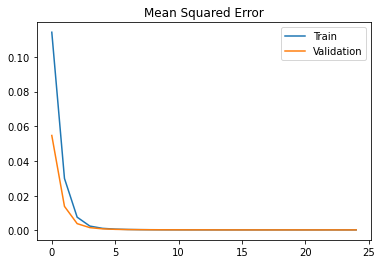

In [8]:
def visualising_data(hist):
    plt.title('Mean Squared Error')
    plt.plot(hist.history['mean_squared_error'], label='Train')
    plt.plot(hist.history['val_mean_squared_error'], label='Validation')
    plt.legend()
    plt.show()
visualising_data(history)

In [9]:
# shows weights of the ANN
# hypermodel.weights
hypermodel.summary()
# print(hypermodel.metrics_names)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 207)               8694      
_________________________________________________________________
dense_1 (Dense)              (None, 300)               62400     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                12040     
Total params: 83,134
Trainable params: 83,134
Non-trainable params: 0
_________________________________________________________________


In [10]:
# INSERT SOMETHING THAT CALCUALTES ALL MEAN SQUARED ERRORS AND PLOTS ON CDF GRAPH

In [11]:
# best_hps.__dict__.keys()
# best_hps.__dict__['values']
hypermodel.save('/Users/jackkelly/Desktop/Building_Model/Tuned_' + str(N_channels) + '_channels_ANN_model.h5')

# Transfer Learning

In [12]:
hypermodel = keras.models.load_model('Tuned_' + str(N_channels) + '_channels_ANN_model.h5')

In [13]:
hypermodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 207)               8694      
_________________________________________________________________
dense_1 (Dense)              (None, 300)               62400     
_________________________________________________________________
dense_2 (Dense)              (None, 40)                12040     
Total params: 83,134
Trainable params: 83,134
Non-trainable params: 0
_________________________________________________________________


In [14]:
model = tf.keras.Sequential()
for layer in hypermodel.layers[:-1]: # go through until last layer
    layer.trainable=False
    model.add(layer)
model.add(keras.layers.Dense(40, activation='sigmoid'))
model.summary()

model.compile(optimizer='adam', loss=keras.losses.MeanSquaredError(), metrics=['mean_squared_error'])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 207)               8694      
_________________________________________________________________
dense_1 (Dense)              (None, 300)               62400     
_________________________________________________________________
dense_3 (Dense)              (None, 40)                12040     
Total params: 83,134
Trainable params: 12,040
Non-trainable params: 71,094
_________________________________________________________________


In [15]:
N_channels = 40
file_path = '/Users/jackkelly/Desktop/Building_Model/Data/40_channels_data_variedlengths_10000.csv'
X_scale, Y_scale = processing_data(N_channels, file_path)
X_train, X_val_and_test, Y_train, Y_val_and_test = train_test_split(X_scale, Y_scale, test_size=0.3)
X_val, X_test, Y_val, Y_test = train_test_split(X_val_and_test, Y_val_and_test, test_size=0.5)

In [16]:
start_time = time.time()
new_hist = model.fit(X_train, Y_train, validation_data=(X_val, Y_val), epochs=40, shuffle=True, verbose=1, batch_size=N_channels+1)
training_time = time.time() - start_time
print(training_time)

Train on 7000 samples, validate on 1500 samples
Epoch 1/40
7000/7000 [==============================] - ETA: 1:26 - loss: 0.2389 - mean_squared_error: 0.23 - ETA: 3s - loss: 0.1743 - mean_squared_error: 0.1743 - ETA: 1s - loss: 0.1408 - mean_squared_error: 0.14 - ETA: 1s - loss: 0.1200 - mean_squared_error: 0.12 - ETA: 0s - loss: 0.1044 - mean_squared_error: 0.10 - ETA: 0s - loss: 0.0932 - mean_squared_error: 0.09 - ETA: 0s - loss: 0.0844 - mean_squared_error: 0.08 - ETA: 0s - loss: 0.0765 - mean_squared_error: 0.07 - ETA: 0s - loss: 0.0692 - mean_squared_error: 0.06 - ETA: 0s - loss: 0.0629 - mean_squared_error: 0.06 - 1s 177us/sample - loss: 0.0615 - mean_squared_error: 0.0615 - val_loss: 0.0101 - val_mean_squared_error: 0.0101
Epoch 2/40
7000/7000 [==============================] - ETA: 0s - loss: 0.0095 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0088 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0079 - mean_squared_error: 0.00 - ETA: 0s - loss: 0.0074 - mean_squared_error: 0.0

7000/7000 [==============================] - ETA: 1s - loss: 2.0851e-04 - mean_squared_error: 2.0851e- - ETA: 0s - loss: 2.1244e-04 - mean_squared_error: 2.1244e- - ETA: 0s - loss: 2.1817e-04 - mean_squared_error: 2.1817e- - ETA: 0s - loss: 2.0982e-04 - mean_squared_error: 2.0982e- - ETA: 0s - loss: 2.2464e-04 - mean_squared_error: 2.2464e- - ETA: 0s - loss: 2.2313e-04 - mean_squared_error: 2.2313e- - ETA: 0s - loss: 2.2471e-04 - mean_squared_error: 2.2471e- - ETA: 0s - loss: 2.2069e-04 - mean_squared_error: 2.2069e- - ETA: 0s - loss: 2.1892e-04 - mean_squared_error: 2.1892e- - ETA: 0s - loss: 2.1904e-04 - mean_squared_error: 2.1904e- - 1s 85us/sample - loss: 2.1982e-04 - mean_squared_error: 2.1982e-04 - val_loss: 2.2307e-04 - val_mean_squared_error: 2.2307e-04
Epoch 13/40
7000/7000 [==============================] - ETA: 0s - loss: 1.0845e-04 - mean_squared_error: 1.0845e- - ETA: 0s - loss: 2.0662e-04 - mean_squared_error: 2.0662e- - ETA: 0s - loss: 2.1189e-04 - mean_squared_error: 2.

7000/7000 [==============================] - ETA: 0s - loss: 1.3609e-04 - mean_squared_error: 1.3609e- - ETA: 0s - loss: 1.1992e-04 - mean_squared_error: 1.1992e- - ETA: 0s - loss: 1.1989e-04 - mean_squared_error: 1.1989e- - ETA: 0s - loss: 1.1911e-04 - mean_squared_error: 1.1911e- - ETA: 0s - loss: 1.1891e-04 - mean_squared_error: 1.1891e- - ETA: 0s - loss: 1.1937e-04 - mean_squared_error: 1.1937e- - ETA: 0s - loss: 1.2080e-04 - mean_squared_error: 1.2080e- - ETA: 0s - loss: 1.2332e-04 - mean_squared_error: 1.2332e- - ETA: 0s - loss: 1.2293e-04 - mean_squared_error: 1.2293e- - ETA: 0s - loss: 1.2483e-04 - mean_squared_error: 1.2483e- - 1s 87us/sample - loss: 1.2634e-04 - mean_squared_error: 1.2634e-04 - val_loss: 1.3289e-04 - val_mean_squared_error: 1.3289e-04
Epoch 23/40
7000/7000 [==============================] - ETA: 0s - loss: 1.4532e-04 - mean_squared_error: 1.4532e- - ETA: 0s - loss: 1.2235e-04 - mean_squared_error: 1.2235e- - ETA: 0s - loss: 1.2140e-04 - mean_squared_error: 1.

7000/7000 [==============================] - ETA: 0s - loss: 1.1597e-04 - mean_squared_error: 1.1597e- - ETA: 0s - loss: 1.1671e-04 - mean_squared_error: 1.1671e- - ETA: 0s - loss: 1.2431e-04 - mean_squared_error: 1.2431e- - ETA: 0s - loss: 1.2008e-04 - mean_squared_error: 1.2008e- - ETA: 0s - loss: 1.1822e-04 - mean_squared_error: 1.1822e- - ETA: 0s - loss: 1.1740e-04 - mean_squared_error: 1.1740e- - ETA: 0s - loss: 1.1538e-04 - mean_squared_error: 1.1538e- - ETA: 0s - loss: 1.1776e-04 - mean_squared_error: 1.1776e- - ETA: 0s - loss: 1.1703e-04 - mean_squared_error: 1.1703e- - ETA: 0s - loss: 1.1806e-04 - mean_squared_error: 1.1806e- - ETA: 0s - loss: 1.2001e-04 - mean_squared_error: 1.2001e- - 1s 94us/sample - loss: 1.1962e-04 - mean_squared_error: 1.1962e-04 - val_loss: 1.2562e-04 - val_mean_squared_error: 1.2562e-04
Epoch 33/40
7000/7000 [==============================] - ETA: 0s - loss: 1.2835e-04 - mean_squared_error: 1.2835e- - ETA: 0s - loss: 1.2503e-04 - mean_squared_error: 1.

In [17]:
eval_result = model.evaluate(X_test, Y_test)

1500/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

 - 0s 49us/sample - loss: 1.5717e-04 - mean_squared_error: 1.2392e-04


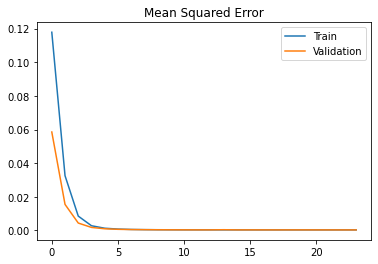

In [18]:
visualising_data(hypermodel_hist)

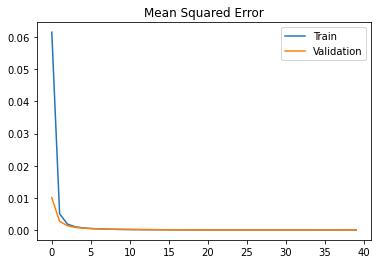

In [19]:
visualising_data(model.history)

In [21]:
hypermodel.evaluate(X_test, Y_test)

1500/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

 - 0s 126us/sample - loss: 7.0649e-04 - mean_squared_error: 6.6559e-04


[0.0006655877650094528, 0.0006655877]